In [1]:
import os
import sys

os.chdir("..")
sys.path.append(os.getcwd())
os.getcwd()

'/Users/nicholaschoong/Documents/QuantumTransformer/old'

In [2]:
from text_classifier.main import main

In [3]:
from config import dev

dev

device(type='mps')

In [10]:
train_loss, train_acc, test_loss, test_acc = main(total_size=3200, batch_size=32)

pos:  1571
neg:  1629
++ There will be 2 transformer blocks
The model has 400,873 trainable parameters


Epoch   1/30:   4%|▍         | 128/3200 [00:00<00:02, 1179.67batch/s]

Epoch 1/30


Epoch   1/30: 100%|██████████| 3200/3200 [00:03<00:00, 926.05batch/s, Loss = 0.6965, AUC = 0.49%] 


Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.696 | Train Acc: 50.69%
	Test Loss: 0.696 |  Test Acc: 49.00%


Epoch   2/30:   4%|▍         | 128/3200 [00:00<00:02, 1256.24batch/s]

Epoch 2/30


Epoch   2/30: 100%|██████████| 3200/3200 [00:03<00:00, 916.11batch/s, Loss = 0.6943, AUC = 0.51%] 


Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.694 | Train Acc: 50.03%
	Test Loss: 0.694 |  Test Acc: 50.50%


Epoch   3/30:   4%|▍         | 128/3200 [00:00<00:02, 1256.49batch/s]

Epoch 3/30


Epoch   3/30: 100%|██████████| 3200/3200 [00:03<00:00, 932.83batch/s, Loss = 0.6940, AUC = 0.49%] 


Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 51.28%
	Test Loss: 0.694 |  Test Acc: 49.34%


Epoch   4/30:   4%|▍         | 128/3200 [00:00<00:02, 1275.90batch/s]

Epoch 4/30


Epoch   4/30: 100%|██████████| 3200/3200 [00:03<00:00, 936.95batch/s, Loss = 0.6932, AUC = 0.51%] 


Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 51.12%
	Test Loss: 0.693 |  Test Acc: 50.66%


Epoch   5/30:   4%|▍         | 128/3200 [00:00<00:02, 1274.43batch/s]

Epoch 5/30


Epoch   5/30: 100%|██████████| 3200/3200 [00:03<00:00, 934.49batch/s, Loss = 0.6923, AUC = 0.52%] 


Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 52.44%
	Test Loss: 0.692 |  Test Acc: 52.25%


Epoch   6/30:   4%|▍         | 128/3200 [00:00<00:02, 1186.13batch/s]

Epoch 6/30


Epoch   6/30: 100%|██████████| 3200/3200 [00:03<00:00, 935.34batch/s, Loss = 0.6913, AUC = 0.53%] 


Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 51.22%
	Test Loss: 0.691 |  Test Acc: 52.66%


Epoch   7/30:   5%|▌         | 160/3200 [00:00<00:02, 1314.92batch/s]

Epoch 7/30


Epoch   7/30: 100%|██████████| 3200/3200 [00:03<00:00, 928.39batch/s, Loss = 0.6926, AUC = 0.50%] 


Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 54.16%
	Test Loss: 0.693 |  Test Acc: 50.31%


Epoch   8/30:   4%|▍         | 128/3200 [00:00<00:02, 1270.42batch/s]

Epoch 8/30


Epoch   8/30: 100%|██████████| 3200/3200 [00:03<00:00, 935.39batch/s, Loss = 0.6896, AUC = 0.53%] 


Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.691 | Train Acc: 51.66%
	Test Loss: 0.690 |  Test Acc: 53.37%


Epoch   9/30:   5%|▌         | 160/3200 [00:00<00:02, 1309.08batch/s]

Epoch 9/30


Epoch   9/30: 100%|██████████| 3200/3200 [00:03<00:00, 915.65batch/s, Loss = 0.6733, AUC = 0.59%] 


Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.683 | Train Acc: 57.38%
	Test Loss: 0.673 |  Test Acc: 58.53%


Epoch  10/30:   4%|▍         | 128/3200 [00:00<00:02, 1274.54batch/s]

Epoch 10/30


Epoch  10/30: 100%|██████████| 3200/3200 [00:03<00:00, 932.78batch/s, Loss = 0.6598, AUC = 0.60%] 


Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.660 | Train Acc: 61.19%
	Test Loss: 0.660 |  Test Acc: 59.91%


Epoch  11/30:   4%|▍         | 128/3200 [00:00<00:02, 1279.28batch/s]

Epoch 11/30


Epoch  11/30: 100%|██████████| 3200/3200 [00:03<00:00, 877.19batch/s, Loss = 0.6452, AUC = 0.63%] 


Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 0.632 | Train Acc: 65.06%
	Test Loss: 0.645 |  Test Acc: 63.44%


Epoch  12/30:   5%|▌         | 160/3200 [00:00<00:02, 1328.64batch/s]

Epoch 12/30


Epoch  12/30: 100%|██████████| 3200/3200 [00:03<00:00, 931.93batch/s, Loss = 0.6363, AUC = 0.66%] 


Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.594 | Train Acc: 69.28%
	Test Loss: 0.636 |  Test Acc: 65.81%


Epoch  13/30:   4%|▍         | 128/3200 [00:00<00:02, 1272.10batch/s]

Epoch 13/30


Epoch  13/30: 100%|██████████| 3200/3200 [00:03<00:00, 920.23batch/s, Loss = 0.6413, AUC = 0.66%] 


Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 0.565 | Train Acc: 70.81%
	Test Loss: 0.641 |  Test Acc: 66.06%


Epoch  14/30:   5%|▌         | 160/3200 [00:00<00:02, 1320.17batch/s]

Epoch 14/30


Epoch  14/30: 100%|██████████| 3200/3200 [00:03<00:00, 942.18batch/s, Loss = 0.6431, AUC = 0.66%] 


Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.535 | Train Acc: 74.28%
	Test Loss: 0.643 |  Test Acc: 65.81%


Epoch  15/30:   5%|▌         | 160/3200 [00:00<00:02, 1318.67batch/s]

Epoch 15/30


Epoch  15/30: 100%|██████████| 3200/3200 [00:03<00:00, 945.70batch/s, Loss = 0.6279, AUC = 0.68%] 


Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 0.514 | Train Acc: 75.62%
	Test Loss: 0.628 |  Test Acc: 68.06%


Epoch  16/30:   5%|▌         | 160/3200 [00:00<00:02, 1332.93batch/s]

Epoch 16/30


Epoch  16/30: 100%|██████████| 3200/3200 [00:03<00:00, 947.80batch/s, Loss = 0.6312, AUC = 0.68%] 


Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.488 | Train Acc: 77.84%
	Test Loss: 0.631 |  Test Acc: 68.28%


Epoch  17/30:   5%|▌         | 160/3200 [00:00<00:02, 1321.87batch/s]

Epoch 17/30


Epoch  17/30: 100%|██████████| 3200/3200 [00:03<00:00, 932.15batch/s, Loss = 0.6296, AUC = 0.70%] 


Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 0.468 | Train Acc: 78.38%
	Test Loss: 0.630 |  Test Acc: 69.53%


Epoch  18/30:   5%|▌         | 160/3200 [00:00<00:02, 1333.21batch/s]

Epoch 18/30


Epoch  18/30: 100%|██████████| 3200/3200 [00:03<00:00, 934.30batch/s, Loss = 0.6336, AUC = 0.71%] 


Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.439 | Train Acc: 80.69%
	Test Loss: 0.634 |  Test Acc: 70.56%


Epoch  19/30:   5%|▌         | 160/3200 [00:00<00:02, 1307.03batch/s]

Epoch 19/30


Epoch  19/30: 100%|██████████| 3200/3200 [00:03<00:00, 921.81batch/s, Loss = 0.6502, AUC = 0.70%] 


Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 0.426 | Train Acc: 81.44%
	Test Loss: 0.650 |  Test Acc: 69.69%


Epoch  20/30:   4%|▍         | 128/3200 [00:00<00:02, 1240.73batch/s]

Epoch 20/30


Epoch  20/30: 100%|██████████| 3200/3200 [00:03<00:00, 939.64batch/s, Loss = 0.6568, AUC = 0.71%] 


Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.403 | Train Acc: 82.91%
	Test Loss: 0.657 |  Test Acc: 70.56%


Epoch  21/30:   5%|▌         | 160/3200 [00:00<00:02, 1320.44batch/s]

Epoch 21/30


Epoch  21/30: 100%|██████████| 3200/3200 [00:03<00:00, 937.13batch/s, Loss = 0.6531, AUC = 0.70%] 


Epoch: 21 | Epoch Time: 0m 3s
	Train Loss: 0.397 | Train Acc: 82.91%
	Test Loss: 0.653 |  Test Acc: 70.06%


Epoch  22/30:   5%|▌         | 160/3200 [00:00<00:02, 1309.31batch/s]

Epoch 22/30


Epoch  22/30: 100%|██████████| 3200/3200 [00:03<00:00, 908.73batch/s, Loss = 0.6512, AUC = 0.71%] 


Epoch: 22 | Epoch Time: 0m 3s
	Train Loss: 0.373 | Train Acc: 84.47%
	Test Loss: 0.651 |  Test Acc: 71.16%


Epoch  23/30:   4%|▍         | 128/3200 [00:00<00:02, 1268.87batch/s]

Epoch 23/30


Epoch  23/30: 100%|██████████| 3200/3200 [00:03<00:00, 923.67batch/s, Loss = 0.6574, AUC = 0.71%] 


Epoch: 23 | Epoch Time: 0m 3s
	Train Loss: 0.352 | Train Acc: 85.38%
	Test Loss: 0.657 |  Test Acc: 71.34%


Epoch  24/30:   5%|▌         | 160/3200 [00:00<00:02, 1328.81batch/s]

Epoch 24/30


Epoch  24/30: 100%|██████████| 3200/3200 [00:03<00:00, 914.15batch/s, Loss = 0.6698, AUC = 0.72%] 


Epoch: 24 | Epoch Time: 0m 3s
	Train Loss: 0.335 | Train Acc: 85.66%
	Test Loss: 0.670 |  Test Acc: 71.62%


Epoch  25/30:   5%|▌         | 160/3200 [00:00<00:02, 1304.72batch/s]

Epoch 25/30


Epoch  25/30: 100%|██████████| 3200/3200 [00:03<00:00, 941.05batch/s, Loss = 0.6968, AUC = 0.71%] 


Epoch: 25 | Epoch Time: 0m 3s
	Train Loss: 0.313 | Train Acc: 87.66%
	Test Loss: 0.697 |  Test Acc: 71.34%


Epoch  26/30:   5%|▌         | 160/3200 [00:00<00:02, 1312.21batch/s]

Epoch 26/30


Epoch  26/30: 100%|██████████| 3200/3200 [00:03<00:00, 941.97batch/s, Loss = 0.6892, AUC = 0.72%] 


Epoch: 26 | Epoch Time: 0m 3s
	Train Loss: 0.312 | Train Acc: 87.22%
	Test Loss: 0.689 |  Test Acc: 71.88%


Epoch  27/30:   5%|▌         | 160/3200 [00:00<00:02, 1293.86batch/s]

Epoch 27/30


Epoch  27/30: 100%|██████████| 3200/3200 [00:03<00:00, 944.26batch/s, Loss = 0.7057, AUC = 0.72%] 


Epoch: 27 | Epoch Time: 0m 3s
	Train Loss: 0.293 | Train Acc: 87.81%
	Test Loss: 0.706 |  Test Acc: 71.66%


Epoch  28/30:   5%|▌         | 160/3200 [00:00<00:02, 1321.47batch/s]

Epoch 28/30


Epoch  28/30: 100%|██████████| 3200/3200 [00:03<00:00, 949.22batch/s, Loss = 0.7419, AUC = 0.72%] 


Epoch: 28 | Epoch Time: 0m 3s
	Train Loss: 0.265 | Train Acc: 89.34%
	Test Loss: 0.742 |  Test Acc: 72.19%


Epoch  29/30:   5%|▌         | 160/3200 [00:00<00:02, 1322.03batch/s]

Epoch 29/30


Epoch  29/30: 100%|██████████| 3200/3200 [00:03<00:00, 948.10batch/s, Loss = 0.7753, AUC = 0.72%] 


Epoch: 29 | Epoch Time: 0m 3s
	Train Loss: 0.239 | Train Acc: 90.66%
	Test Loss: 0.775 |  Test Acc: 71.88%


Epoch  30/30:   5%|▌         | 160/3200 [00:00<00:02, 1318.63batch/s]

Epoch 30/30


Epoch  30/30: 100%|██████████| 3200/3200 [00:03<00:00, 941.75batch/s, Loss = 0.7727, AUC = 0.73%] 

Epoch: 30 | Epoch Time: 0m 3s
	Train Loss: 0.244 | Train Acc: 90.62%
	Test Loss: 0.773 |  Test Acc: 72.53%
TOTAL TIME = 103.15s
BEST ACC = 0.73% AT EPOCH 30


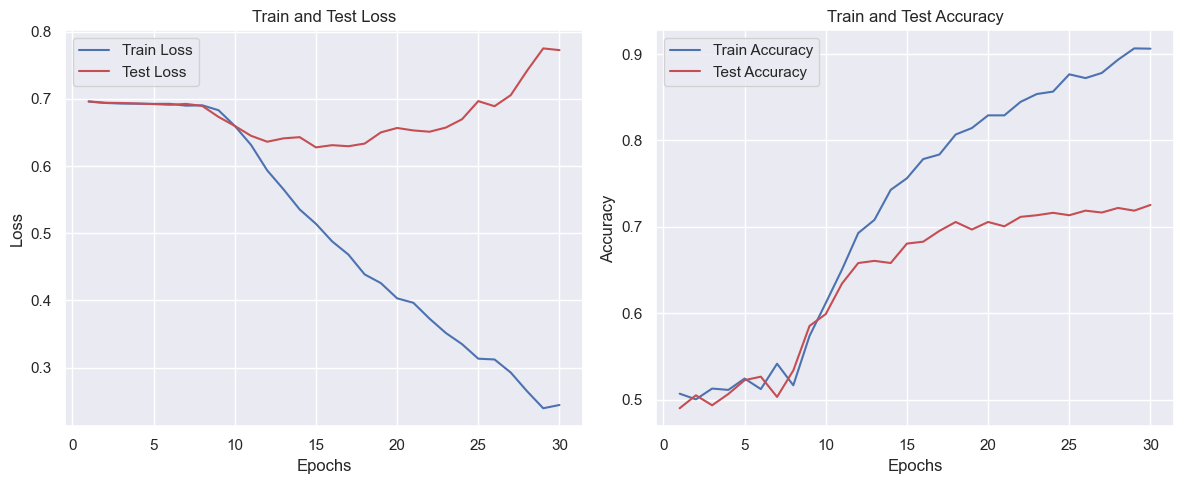

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
train_loss

[0.6960169613361359,
 0.6940807330608368,
 0.6931605803966522,
 0.6929070317745208,
 0.6926468902826309,
 0.6927391982078552,
 0.6900188666582108,
 0.6905308216810226,
 0.6832095766067505,
 0.6598665809631348,
 0.6316676437854767,
 0.5936006125807762,
 0.5654897522926331,
 0.5354303461313248,
 0.5140927800536156,
 0.48789903372526167,
 0.46828561812639236,
 0.43878044188022614,
 0.4257997040450573,
 0.4031629540026188,
 0.3965213057398796,
 0.37282002344727516,
 0.35159814536571504,
 0.3349228938668966,
 0.3132855226844549,
 0.31213269479572775,
 0.29266745269298555,
 0.2649648032337427,
 0.23948229864239692,
 0.24437259294092656]

In [13]:
train_acc

[0.506875,
 0.5003125,
 0.5128125,
 0.51125,
 0.524375,
 0.5121875,
 0.5415625,
 0.5165625,
 0.57375,
 0.611875,
 0.650625,
 0.6928125,
 0.708125,
 0.7428125,
 0.75625,
 0.7784375,
 0.78375,
 0.806875,
 0.814375,
 0.8290625,
 0.8290625,
 0.8446875,
 0.85375,
 0.8565625,
 0.8765625,
 0.8721875,
 0.878125,
 0.8934375,
 0.9065625,
 0.90625]

In [14]:
test_loss

[0.696473097205162,
 0.6943355756998062,
 0.6939944142103195,
 0.6932471340894699,
 0.6923388373851777,
 0.6912820023298264,
 0.6926061433553695,
 0.6895923453569412,
 0.6732681506872177,
 0.6598484015464783,
 0.6451687866449356,
 0.6363254252076149,
 0.6413342693448066,
 0.6431222108006477,
 0.627896381020546,
 0.6312106484174729,
 0.6295885029435158,
 0.6335701704025268,
 0.6502384832501411,
 0.6568005946278572,
 0.6531363624334335,
 0.651213350892067,
 0.6573942810297012,
 0.6698039978742599,
 0.6967843732237816,
 0.6891774147748947,
 0.7057016584277153,
 0.741902285516262,
 0.7752729111909866,
 0.772712664604187]

In [15]:
test_acc 

[0.49,
 0.505,
 0.4934375,
 0.5065625,
 0.5225,
 0.5265625,
 0.503125,
 0.53375,
 0.5853125,
 0.5990625,
 0.634375,
 0.658125,
 0.660625,
 0.658125,
 0.680625,
 0.6828125,
 0.6953125,
 0.705625,
 0.696875,
 0.705625,
 0.700625,
 0.7115625,
 0.7134375,
 0.71625,
 0.7134375,
 0.71875,
 0.7165625,
 0.721875,
 0.71875,
 0.7253125]